# Troubleshooting of Fitting to Double Mutant Induction Profiles 

© 2018 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

--- 

In [34]:
import sys
sys.path.insert(0, '../../')
import pandas as pd
import numpy as np
import pystan 
import matplotlib.pyplot as plt
import mut.viz
import mut.stats
import bebi103.viz
import bokeh.io
bokeh.io.output_notebook()
mut.viz.plotting_style()
%load_ext stanmagic

Loading BokehJS ...

The stanmagic extension is already loaded. To reload it, use:
  %reload_ext stanmagic


I'm having trouble fitting curves to a few specific double mutants.  Thepoint of this notebook is to troubleshoot this fitting of a Hill function to a particular double mutant, Y20I, Q294V.

(0, 1.2)

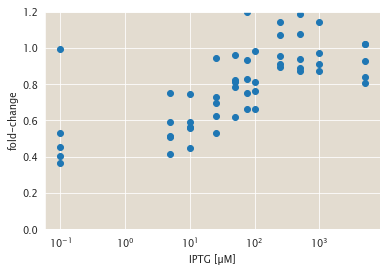

In [72]:
# Load the data
data = pd.read_csv('../../data/csv/compiled_data.csv')
data = data[data['mutant']=='Y20I-Q294V']

# Plot the data. 
plt.semilogx(data['IPTGuM'], data['fold_change'], 'o')
plt.xlabel('IPTG [µM]')
plt.ylabel('fold-change')
plt.ylim([0, 1.2])

This should absolutely be tractable for a Hill function. Let's define the hill function using stan.  

In [73]:
%%stan -v hill
data {
    int N; 
    vector[N] c;
    vector[N] fc;
}

parameters {
    real<lower=0, upper=1> a;
    real<lower=0, upper=1> b;
    real<lower=0> K;
    real<lower=0> n;
    real<lower=0> sigma;
}

model {
    vector[N] mu;
    a ~ normal(0, 1);
    b ~ normal(0, 1);
    K ~ normal(0, 100);
    n ~ normal(0, 1);
    sigma ~ normal(0, 1);
    
    for (i in 1:N) {
    mu[i] = a + b * ((c[i] / K)^n / (1 + (c[i] / K)^n));
        }
    fc ~ normal(mu, sigma);
}

generated quantities {
    real y_rep[N];
    real mu;
    for (i in 1:N) {
        mu = a + b * ((c[i] / K)^n / (1 + (c[i] / K)^n));
        y_rep[i] = normal_rng(mu, sigma);
    }
}
                   

Using pystan.stanc compiler..
-------------------------------------------------------------------------------
Model compiled successfully. Output stored in hill object.
Type hill in a cell to see a nicely formatted code output in a notebook
     ^^^^
Access model compile output properties
hill.model_file -> Name of stan_file [None]
hill.model_name -> Name of stan model [None]
hill.model_code -> Model code [data {     int N;    ....]


In [ ]:
# Compile the model. 
model = pystan.StanModel(model_code=hill.model_code)

In [75]:
# Define the data dictionary and sample. 
_data = data[data['IPTGuM'] > 0]
data_dict = {'N':len(data), 'c':data['IPTGuM'], 'fc':data['fold_change']}
samples = model.sampling(data=data_dict)
samples_df = samples.to_dataframe()

In [76]:
# Vizualize the sampling. 
p = bebi103.viz.corner(samples, vars=['a', 'b', 'K', 'n', 'sigma'], datashade=True)
bokeh.io.show(p)

Okay, the sampling looks good. Let's look at the posterior predictive checks.  

In [77]:
p = bebi103.viz.predictive_ecdf(samples, name='y_rep', data=data['fold_change'], diff=True)
bokeh.io.show(p)

Great! It looks like all of our observed data rests within the percentiles of our posterior predictive distribution. We can now look at how good of a fit our inference is.

Text(0, 0.5, 'fold-change')

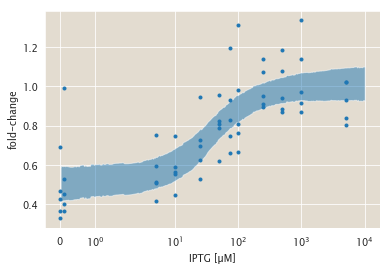

In [78]:
# Define a range of concentrations. 
c_range = np.logspace(-2, 4, 500)

# Define the 95% credible regions. 
cred_region = np.zeros((2, len(c_range)))
for i, c in enumerate(c_range):
    hill_fit = samples_df['a'] + samples_df['b'] * (c /samples_df['K'])**samples_df['n'] /\
            (1 + (c / samples_df['K'])**samples_df['n'])
    cred_region[:, i] = mwc.stats.compute_hpd(hill_fit, 0.95)
    
# Plot the credible regions over the data. 
summarized_data = data.groupby(['IPTGuM'],)
plt.plot(data['IPTGuM'], data['fold_change'], 'o', ms=3)
plt.xscale('symlog')
plt.fill_between(c_range, cred_region[0,:], cred_region[1, :], alpha=0.5)
plt.xlabel('IPTG [µM]')
plt.ylabel('fold-change')

There's the problem! The data at $c=0$ is nonsense! Where is this coming from?? 

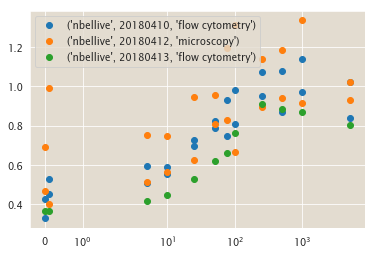

In [79]:
for g, d in data.groupby(['username', 'date', 'method']):
    plt.plot(d['IPTGuM'], d['fold_change'], 'o', label=g)
    
plt.xscale('symlog')
plt.legend()

In [80]:
data[]

SyntaxError: invalid syntax (<ipython-input-80-1527323af517>, line 1)